In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

"""
Loading the data
"""
pd.options.display.max_colwidth = 1500
pd.options.display.max_rows = 1000

df = pd.read_csv(r'books_and_genres.csv')

# drop the extra index column
df = df.drop(columns=df.columns[0])

df.head()

,title,text,genres
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Distributed Proofreaders\n\n\n\n\n SENECA\n\n APOCOLOCYNTOSIS\n\n WITH AN ENGLISH TRANSLATION BY\n\n W.H.D. ROUSE, M.A. LITT. D.\n\n MCMXX\n\n\n\n\n\nINTRODUCTION\n\nThis piece is ascribed to Seneca by ancient tradition; it is impossible\nto prove that it is his, and impossible to prove that it is not. The\nmatter will probably continue to be decided by every one according to his\nview of Seneca's character and abilities: in the matters of style and of\nsentiment much may be said on both sides. Dion Cassius (lx, 35) says that\nSeneca composed an [Greek: apokolokuntosis] or Pumpkinification of\nClaudius after his death, the title being a parody of the usual\n[Greek: apotheosis]; but this title is not given in the MSS. of the Ludus\nde Morte Claudii, nor is there anything in the piece which suits the title\nvery well.\n\nAs a literary form, the piece belongs to the class called\n_Satura Menippea_, a satiric medley in prose and verse.\n\nThis text is that of Buecheler, with a few trifling changes, which are\nindicated in the notes. We have been courteously allowed by Messrs\nWeidmann to use this text. I have to acknowledge the help of Mr Ball's\nnotes, from which I have taken a few references; but my translation was\nmade many years ago.\n\nW.H.D. ROUSE.\n\n\n\n\n\nBIBLIOGRAPHY\n\n_Editio Princeps:_ Lucii Annaei Senecae in morte\n Claudii Caesaris Lud...","{'21st-century', 'history', 'roman', 'classics', 'religion', 'novels', 'philosophy', 'fiction', 'literature', 'short-stories', 'politics', 'non-fiction', 'read-for-school', 'poetry', 'historical', 'humor'}"
1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distributed Proofreaders\n\n\n\n\nTHE HOUSE ON THE BORDERLAND\n\nWilliam Hope Hodgson\n\n\n_From the Manuscript discovered in 1877 by Messrs. Tonnison and\nBerreggnog in the Ruins that lie to the South of the Village of\nKraighten, in the West of Ireland. Set out here, with Notes_.\n\n\nTO MY FATHER\n_(Whose feet tread the lost aeons)_\n\nOpen the door,\n And listen!\nOnly the wind's muffled roar,\n And the glisten\nOf tears 'round the moon.\n And, in fancy, the tread\nOf vanishing shoon--\n Out in the night with the Dead.\n\n""Hush! And hark\n To the sorrowful cry\nOf the wind in the dark.\n Hush and hark, without murmur or sigh,\n To shoon that tread the lost aeons:\n To the sound that bids you to die.\nHush and hark! Hush and Hark!""\n _Shoon of the Dead_\n\n\n\n\nAUTHOR'S INTRODUCTION TO THE MANUSCRIPT\n\nMany are the hours in which I have pondered upon the story that is set\nforth in the following pages. I trust that my instincts are not awry\nwhen they prompt me to leave the account, in simplicity, as it was\nhanded to me.\n\nAnd the MS. itself--You must picture me, when first it was given into my\ncare, turning it over, curiously, and making a swift, jerky examination.\nA small book it is; but thick, and all, save the last few pages, filled\nwith a quaint but legible handwriting, and writ very close. I have the\nqueer, faint, pit-water smell of it in my nostrils now as I write, and\nmy f...","{'horror', 'mystery', 'classics', 'science-fiction', 'fantasy', 'novels', 'literature', 'fiction', 'paranormal', '20th-century', 'adult', 'speculative-fiction', 'supernatural', 'dark'}"
2,the warriors,"Produced by Charles Aldarondo, Charlie Kirschner\nand the Online Distributed Proofreading Team.\n\n\n\n\nTHE WARRIORS\n\nBY ANNA ROBERTSON BROWN LINDSAY PH.D.\n\nAUTHOR OF\n\nWHAT IS WORTH WHILE?\nCULTURE AND REFORM\nTHE VICTORY OF OUR FAITH\n\n\n\n\nPREFACE\n\nThis work was begun nearly five years ago. Since then, the whole face of\nAmerican history has changed. We have had the Spanish-American War, and\nthe opening-up of our new possessions. In this period of time Gladstone,\nLi Hung Chang, and Queen Victoria have died; there has also occurred the\nassassination of the Empress of Austria and of President McKinley. There\nhas bee

In [2]:
"""
Basic formatting
"""
# stringify all text
df['text'] = df['text'].map(str)
df = df.replace({r'\r\n|\r|\n': ' '}, regex=True)

df.head(5)

,title,text,genres
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Distributed Proofreaders SENECA APOCOLOCYNTOSIS WITH AN ENGLISH TRANSLATION BY W.H.D. ROUSE, M.A. LITT. D. MCMXX INTRODUCTION This piece is ascribed to Seneca by ancient tradition; it is impossible to prove that it is his, and impossible to prove that it is not. The matter will probably continue to be decided by every one according to his view of Seneca's character and abilities: in the matters of style and of sentiment much may be said on both sides. Dion Cassius (lx, 35) says that Seneca composed an [Greek: apokolokuntosis] or Pumpkinification of Claudius after his death, the title being a parody of the usual [Greek: apotheosis]; but this title is not given in the MSS. of the Ludus de Morte Claudii, nor is there anything in the piece which suits the title very well. As a literary form, the piece belongs to the class called _Satura Menippea_, a satiric medley in prose and verse. This text is that of Buecheler, with a few trifling changes, which are indicated in the notes. We have been courteously allowed by Messrs Weidmann to use this text. I have to acknowledge the help of Mr Ball's notes, from which I have taken a few references; but my translation was made many years ago. W.H.D. ROUSE. BIBLIOGRAPHY _Editio Princeps:_ Lucii Annaei Senecae in morte Claudii Caesaris Ludus nuper repertus: Rome, 1513. _Latest critical...","{'21st-century', 'history', 'roman', 'classics', 'religion', 'novels', 'philosophy', 'fiction', 'literature', 'short-stories', 'politics', 'non-fiction', 'read-for-school', 'poetry', 'historical', 'humor'}"
1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distributed Proofreaders THE HOUSE ON THE BORDERLAND William Hope Hodgson _From the Manuscript discovered in 1877 by Messrs. Tonnison and Berreggnog in the Ruins that lie to the South of the Village of Kraighten, in the West of Ireland. Set out here, with Notes_. TO MY FATHER _(Whose feet tread the lost aeons)_ Open the door, And listen! Only the wind's muffled roar, And the glisten Of tears 'round the moon. And, in fancy, the tread Of vanishing shoon-- Out in the night with the Dead. ""Hush! And hark To the sorrowful cry Of the wind in the dark. Hush and hark, without murmur or sigh, To shoon that tread the lost aeons: To the sound that bids you to die. Hush and hark! Hush and Hark!"" _Shoon of the Dead_ AUTHOR'S INTRODUCTION TO THE MANUSCRIPT Many are the hours in which I have pondered upon the story that is set forth in the following pages. I trust that my instincts are not awry when they prompt me to leave the account, in simplicity, as it was handed to me. And the MS. itself--You must picture me, when first it was given into my care, turning it over, curiously, and making a swift, jerky examination. A small book it is; but thick, and all, save the last few pages, filled with a quaint but legible handwriting, and writ very close. I have the queer, faint, pit-water smell of it in my nostrils now as I write, and my fingers have subconscious memories of the soft, ""clo...","{'horror', 'mystery', 'classics', 'science-fiction', 'fantasy', 'novels', 'literature', 'fiction', 'paranormal', '20th-century', 'adult', 'speculative-fiction', 'supernatural', 'dark'}"
2,the warriors,"Produced by Charles Aldarondo, Charlie Kirschner and the Online Distributed Proofreading Team. THE WARRIORS BY ANNA ROBERTSON BROWN LINDSAY PH.D. AUTHOR OF WHAT IS WORTH WHILE? CULTURE AND REFORM THE VICTORY OF OUR FAITH PREFACE This work was begun nearly five years ago. Since then, the whole face of American history has changed. We have had the Spanish-American War, and the opening-up of our new possessions. In this period of time Gladstone, Li Hung Chang, and Queen Victoria have died; there has also occurred the assassination of the Empress of Austria and of President McKinley. There has been the Chinese persecution, the destruction of Galveston by storm and of Martinique by volcanic 

In [3]:
"""
Methods that will be used in the next block to try to source a published date
"""
import re
import roman;
from roman import InvalidRomanNumeralError

# regex for finding Gregorian or Roman publish dates
rn_year_regex = r'\b(.[M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3}))]{3,})\b'
modern_year_regex = r'(\b\d{4}\b)'
valid_year_regex = f'{modern_year_regex}|{rn_year_regex}'

# methods for finding above regex matches in text
find_year = re.compile('('+rn_year_regex+'|'+modern_year_regex+')');
find_modern_year = re.compile('('+modern_year_regex+')')

def is_right_era(int_date):
    return 1000 < int_date < 1922

def get_valid_date(date):
    try:
        int_date = int(date)
    except (ValueError, TypeError):
        return 0
    
    if is_right_era(int_date):
        return int_date
    
    return 0

def convert_date(date):
    if date == 'no date':
        return 0
    
    valid_date = get_valid_date(date)
    if valid_date:
        return valid_date
    
    try:
        number = roman.fromRoman(date.strip())
    except (InvalidRomanNumeralError, TypeError, AttributeError) as e:
        return 0
    
    valid_date = get_valid_date(number)
    return int(number)




In [4]:
"""
Try to source a published date from the intro text of each book and write to new "year" column
"""

# try to find either a Roman or Gregorian year within the text of each book, and insert into the "year" column
df['year'] = df['text'].map(lambda t: (find_year.search( t[0:1000]) or ["no date"])[0])

# no date before
print(len(df.loc[df['year'] == 'no date']))
df['year'] = df['year'].map(convert_date)

# no date after :(
print(len(df.loc[df['year'] == 0]))


3721
4797


In [5]:
"""
Methods that will be used in the next block to try to source published date from Google Books
"""

import requests
import time

# ADD YOUR GOOGLE BOOKS API CLIENT SECRET HERE IF YOU WOULD LIKE TO RUN THIS PORTION
secret = ''

def is_valid_date(date):
    try:
        int_date = int(date)
    except ValueError:
        return False
    return is_right_era(int_date)

def find_publication_year_from_item(item):
    published_date = item['volumeInfo'].get('publishedDate', '')
    if published_date and is_valid_date(published_date):
        return published_date
    
    # if there is no valid publishedDate, search in the description text of the response
    description = item['volumeInfo'].get('description', '')
    possible_dates = [date[0] for date in find_modern_year.findall(description) if is_valid_date(date[0])]
    if possible_dates:
        return min(possible_dates)

# check the Google Books API by a book's title in order to get the publication year
def get_publication_year(title):
    if not secret:
        print('Please assign value to "secret" variable above with your Google Books API key')
        return
    
    # avoid per-minute rate limiting
    time.sleep(0.05)
    url = f'https://www.googleapis.com/books/v1/volumes?q={title}&key={secret}'
    response = requests.get(url)
    
    try:
        items = response.json()['items']
    except KeyError as e:
        print('No matches found for ', title, response.json())
        return 0
    
    possible_years = [found for item in items if (found := find_publication_year_from_item(item)) is not None]
    if possible_years:
        year = min(possible_years)
        print(f'{title}: {year}')
        return year
    
    print('could not find year for title ', title)
    return 0


In [6]:
"""
Loop over the rows missing a publication year and run the above methods to attempt to fill it.
This needs to be done in batches because of rate limiting.

CSV with saved results imported in file in leui of live fetching. See commented out block below
if you would like to test it (you will need a Google Book API client key)
"""

# If you would like to test this out, uncomment the block below and use your own secret key in the block above
# dfcopy = df.copy()[0:100]
# dfcopy.loc[dfcopy['year'] == 0, 'year'] = dfcopy.loc[dfcopy['year'] == 0]['title'].apply(get_publication_year)

# read from the already compiled set instead of fetching live from Google Books API
dfFull = pd.read_csv('fullset.csv')

# Extra formatting!
# Force the year into an int and the text into a string
dfFull.year = dfFull.year.astype('int')
dfFull['text'] = dfFull['text'].astype(str)

# Drop the "genres" column as we will not use it
dfFull = dfFull.drop("genres", axis=1)
dfFull.head(3)

,title,text,year
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Distributed Proofreaders SENECA APOCOLOCYNTOSIS WITH AN ENGLISH TRANSLATION BY W.H.D. ROUSE, M.A. LITT. D. MCMXX INTRODUCTION This piece is ascribed to Seneca by ancient tradition; it is impossible to prove that it is his, and impossible to prove that it is not. The matter will probably continue to be decided by every one according to his view of Seneca's character and abilities: in the matters of style and of sentiment much may be said on both sides. Dion Cassius (lx, 35) says that Seneca composed an [Greek: apokolokuntosis] or Pumpkinification of Claudius after his death, the title being a parody of the usual [Greek: apotheosis]; but this title is not given in the MSS. of the Ludus de Morte Claudii, nor is there anything in the piece which suits the title very well. As a literary form, the piece belongs to the class called _Satura Menippea_, a satiric medley in prose and verse. This text is that of Buecheler, with a few trifling changes, which are indicated in the notes. We have been courteously allowed by Messrs Weidmann to use this text. I have to acknowledge the help of Mr Ball's notes, from which I have taken a few references; but my translation was made many years ago. W.H.D. ROUSE. BIBLIOGRAPHY _Editio Princeps:_ Lucii Annaei Senecae in morte Claudii Caesaris Ludus nuper repertus: Rome, 1513. _Latest critical...",1920
1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distributed Proofreaders THE HOUSE ON THE BORDERLAND William Hope Hodgson _From the Manuscript discovered in 1877 by Messrs. Tonnison and Berreggnog in the Ruins that lie to the South of the Village of Kraighten, in the West of Ireland. Set out here, with Notes_. TO MY FATHER _(Whose feet tread the lost aeons)_ Open the door, And listen! Only the wind's muffled roar, And the glisten Of tears 'round the moon. And, in fancy, the tread Of vanishing shoon-- Out in the night with the Dead. ""Hush! And hark To the sorrowful cry Of the wind in the dark. Hush and hark, without murmur or sigh, To shoon that tread the lost aeons: To the sound that bids you to die. Hush and hark! Hush and Hark!"" _Shoon of the Dead_ AUTHOR'S INTRODUCTION TO THE MANUSCRIPT Many are the hours in which I have pondered upon the story that is set forth in the following pages. I trust that my instincts are not awry when they prompt me to leave the account, in simplicity, as it was handed to me. And the MS. itself--You must picture me, when first it was given into my care, turning it over, curiously, and making a swift, jerky examination. A small book it is; but thick, and all, save the last few pages, filled with a quaint but legible handwriting, and writ very close. I have the queer, faint, pit-water smell of it in my nostrils now as I write, and my fingers have subconscious memories of the soft, ""clo...",1877
2,the warriors,"Produced by Charles Aldarondo, Charlie Kirschner and the Online Distributed Proofreading Team. THE WARRIORS BY ANNA ROBERTSON BROWN LINDSAY PH.D. AUTHOR OF WHAT IS WORTH WHILE? CULTURE AND REFORM THE VICTORY OF OUR FAITH PREFACE This work was begun nearly five years ago. Since then, the whole face of American history has changed. We have had the Spanish-American War, and the opening-up of our new possessions. In this period of time Gladstone, Li Hung Chang, and Queen Victoria have died; there has also occurred the assassination of the Empress of Austria and of President McKinley. There has been the Chinese persecution, the destruction of Galveston by storm and of Martinique by volcanic action. Wireless telegraphy has been discovered, and the source of the spread of certain fevers. In this time have been carried on gigantic engineering undertakings,--the Trans-Siberian Railroad, the Trans-Balkan Railroad, the rebuilding of New York. We have also looked upon the consolidation of vast forces of steel, iron, sugar, shipping, and other trusts. We have witnessed an extrao

In [7]:
"""
Helper method to determine whether a certain book has adequately long text
"""
MIN_FULL_TEXT = 15000
def is_acceptable_length(text, length=MIN_FULL_TEXT):
    if type(text) != str:
        return False
    if len(text) < length:
        return False


In [8]:
print('Book count before removing undated and outliers: ', len(dfFull))

print('Number of books without dates to be removed: ', len(dfFull.loc[dfFull.year == 0]))
dfFull = dfFull.drop(dfFull[dfFull.year== 0].index)

# drop the books from before 1775 - not enough examples
print('Number of books from before 1775, to be removed: ', len(dfFull.loc[dfFull.year<1775]))
dfFull = dfFull.drop(dfFull[dfFull.year < 1775].index)

# drop books after 1922 - these are errors
print('Number of books from after 1922, to be removed: ', len(dfFull.loc[dfFull.year>1922]))
dfFull = dfFull.drop(dfFull[dfFull.year > 1922].index)

# drop any books without text or not enough text
print('Number of books with too short or absent text, to be removed: ', len(dfFull[dfFull.text.apply(is_acceptable_length) == False]))
dfFull = dfFull.drop(dfFull[dfFull.text.apply(is_acceptable_length) == False].index)

print('Dropping duplicates')
dfFull = dfFull.drop_duplicates(subset='title', keep='first')

print('New book count: ', len(dfFull))

dfFull.head()

Book count before removing undated and outliers:  10633
Number of books without dates to be removed:  946
Number of books from before 1775, to be removed:  975
Number of books from after 1922, to be removed:  143
Number of books with too short or absent text, to be removed:  460
Dropping duplicates
New book count:  7279


,title,text,year
0,apocolocyntosis,"Produced by Ted Garvin, Ben Courtney and PG Distributed Proofreaders SENECA APOCOLOCYNTOSIS WITH AN ENGLISH TRANSLATION BY W.H.D. ROUSE, M.A. LITT. D. MCMXX INTRODUCTION This piece is ascribed to Seneca by ancient tradition; it is impossible to prove that it is his, and impossible to prove that it is not. The matter will probably continue to be decided by every one according to his view of Seneca's character and abilities: in the matters of style and of sentiment much may be said on both sides. Dion Cassius (lx, 35) says that Seneca composed an [Greek: apokolokuntosis] or Pumpkinification of Claudius after his death, the title being a parody of the usual [Greek: apotheosis]; but this title is not given in the MSS. of the Ludus de Morte Claudii, nor is there anything in the piece which suits the title very well. As a literary form, the piece belongs to the class called _Satura Menippea_, a satiric medley in prose and verse. This text is that of Buecheler, with a few trifling changes, which are indicated in the notes. We have been courteously allowed by Messrs Weidmann to use this text. I have to acknowledge the help of Mr Ball's notes, from which I have taken a few references; but my translation was made many years ago. W.H.D. ROUSE. BIBLIOGRAPHY _Editio Princeps:_ Lucii Annaei Senecae in morte Claudii Caesaris Ludus nuper repertus: Rome, 1513. _Latest critical...",1920
1,the house on the borderland,"Produced by Suzanne Shell, Sjaani and PG Distributed Proofreaders THE HOUSE ON THE BORDERLAND William Hope Hodgson _From the Manuscript discovered in 1877 by Messrs. Tonnison and Berreggnog in the Ruins that lie to the South of the Village of Kraighten, in the West of Ireland. Set out here, with Notes_. TO MY FATHER _(Whose feet tread the lost aeons)_ Open the door, And listen! Only the wind's muffled roar, And the glisten Of tears 'round the moon. And, in fancy, the tread Of vanishing shoon-- Out in the night with the Dead. ""Hush! And hark To the sorrowful cry Of the wind in the dark. Hush and hark, without murmur or sigh, To shoon that tread the lost aeons: To the sound that bids you to die. Hush and hark! Hush and Hark!"" _Shoon of the Dead_ AUTHOR'S INTRODUCTION TO THE MANUSCRIPT Many are the hours in which I have pondered upon the story that is set forth in the following pages. I trust that my instincts are not awry when they prompt me to leave the account, in simplicity, as it was handed to me. And the MS. itself--You must picture me, when first it was given into my care, turning it over, curiously, and making a swift, jerky examination. A small book it is; but thick, and all, save the last few pages, filled with a quaint but legible handwriting, and writ very close. I have the queer, faint, pit-water smell of it in my nostrils now as I write, and my fingers have subconscious memories of the soft, ""clo...",1877
3,a voyage to the moon,"Produced by Christine De Ryck, Stig M. Valstad, Suzanne L. Shell and PG Distributed Proofreaders A VOYAGE TO THE MOON: WITH SOME ACCOUNT OF THE MANNERS AND CUSTOMS, SCIENCE AND PHILOSOPHY, OF THE PEOPLE OF MOROSOFIA, AND OTHER LUNARIANS. BY GEORGE TUCKER (JOSEPH ATTERLEY) ""It is the very error of the moon, She comes more near the earth than she was wont, And makes men mad.""--_Othello_. 1827 CONTENTS. CHAPTER I. Atterley's birth and education--He makes a voyage-- Founders off the Burman coast--Adventures in that Empire--Meets with a learned Brahmin from Benares. CHAPTER II. The Brahmin's illness--He reveals an important secret to Atterley--Curious information concerning the Moon--The Glonglims--They plan a voyage to the Moon. CHAPTER III. The Brahmin and Atterley prepare for their voyage-- Description of their travelling machine--Incidents of the voyage--The appearance of the earth; Africa; Greece--The Brahmin's speculations on the different races of men--National character. CHAPTER IV. Continuation of the voyage--View of Europe; Atlantic Ocean; America--Sp

Histogram of the distribution of publication year. Data is heavily skewed towards the later years of the set. The first 75 years of the dataset contains only ~1/3 of the total amount of books, while the last 72 years of the date range of the set contains 2/3rds of the total books. A full 45% of the books are from 1900-1922.

Between 1775-1850 books: 32%
Between 1850-1900 books:23%
Between 1900-1922 books: 45%


Text(0.5, 1.05, 'Distribution of books across year published')

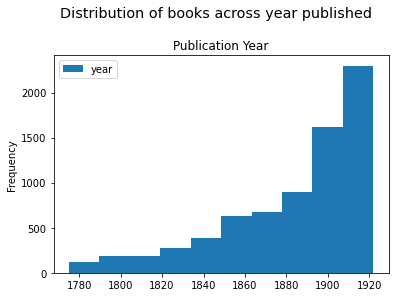

In [9]:
import matplotlib.pyplot as plt
# uncomment this statement to see the count for each year
# print(dfFull['year'].value_counts(ascending=True).sort_index())
print(f'Between 1775-1850 books: {round(len(dfFull.loc[dfFull.year<1875])/len(dfFull)*100)}%')
print(f'Between 1850-1900 books:{round(len(dfFull.loc[(dfFull.year>=1875) & (dfFull.year < 1900)])/len(dfFull)*100)}%')
print(f'Between 1900-1922 books: {round(len(dfFull.loc[(dfFull.year>=1900)& (dfFull.year <= 1922)])/len(dfFull)*100)}%')

dfFull.plot(kind='hist', title='Publication Year')
plt.suptitle('Distribution of books across year published', x=0.5, y=1.05, ha='center', fontsize='x-large')

In [10]:
"""
Define testing and training books
"""
# testing books are every 5th book for each year according to the original dataset
# or if there are fewer than 5 books, the first book. 
testing_books = []
did_it = []
for year in range(1775, 1923):
    books_from_year = list(dfFull[dfFull.year == year].index)
    if len(books_from_year) < 5:
        testing_books.append(books_from_year[0])
    testing_books.extend(books_from_year[::5]) # we want 20% testing dat

def get_is_testing(row):
    if row.name in testing_books:
        did_it.append(row.name)
        row['test'] = True
    else:
        row['test'] = False
    return row
        
dfFull = dfFull.apply(get_is_testing, axis=1)


To have a more even distribution of the dataset, as well as to have more manageable data points that the text of an entire book, I create 200 data points for each year represented in the set. The 200 points are 5000 character portions of the books attributed to that year. For years with only a few books, the points from that year will have less variety, perhaps yielding worse results than the years with a variety of different books. I do this before tokenizing and other processing the text as the process will be less intense once the texts have been truncated.

In [11]:
"""
Create new dataframe for final data. Each year will have 200 rows, each with a unique portion of text sourced
from a book published in that year
"""

all_years = []
PER_YEAR_COUNT = 200

for year in range(1775, 1923):
    years = [year]*PER_YEAR_COUNT
    all_years.extend(years)

print(len(all_years))
dfPas = pd.DataFrame(columns = ['title', 'passage', 'year', 'test'])
dfPas['year'] = all_years
dfPas['index'] = dfPas.index


pd.concat([dfPas.head(2), dfPas.tail(2)])

29600


,title,passage,year,test,index
0,NaN,NaN,1775,NaN,0
1,NaN,NaN,1775,NaN,1
29598,NaN,NaN,1922,NaN,29598
29599,NaN,NaN,1922,NaN,29599


In [12]:
import random
import copy
PASSAGE_LENGTH = 5000

dfFullCopy = dfFull.copy()
no_continue_list = []

def get_full_text(row):
    index = row['index']
    index_for_year = index % PER_YEAR_COUNT

    books_from_year = list(dfFullCopy[dfFullCopy.year == row['year']].index)

    # we have exhausted all the text from the books from this year. There are a few "bad" years with only 4 books
    if not len(books_from_year):
        print(f'THERE ARE NO BOOKS LEFT FOR {row.year}. NOT CONTINUING WITH THIS YEAR.')
        raise ValueError('Depleted books')
    
    index_in_book_list = index_for_year % len(books_from_year)
    book_index = books_from_year[index_in_book_list]
    
    book = dfFullCopy.loc[book_index]
    is_test = book['test']
    full_text = copy.copy(book['text'])

    return (full_text, book_index, book['title'], is_test)

def get_passage(row):
    if row['year'] in no_continue_list:
        return
    
    try:
        full_text, book_index, book_title, is_test = get_full_text(row)
    except ValueError:
        no_continue_list.append(row['year'])
        return
    
    # # testing books are every 5th book for each year according to the original dataset
    # # or if there are fewer than 5 books, the first book. 
    # books_from_year_original = list(dfFull[dfFull.year == row['year']].index)
    # testing_books = books_from_year_original[::5]
    # row['test'] = book_index == 0 if len(books_from_year_original) < 5 else book_index in testing_books 
    
    # print(f'Creating excerpt for {row.year}: from {book_title}.')
    
    max_start_point = len(full_text) - PASSAGE_LENGTH
    start_point = random.randint(0, max_start_point)
    end_point = start_point+PASSAGE_LENGTH
    passage = full_text[start_point:end_point]
    
    if not len(passage) == PASSAGE_LENGTH:
        print(f'SOMETHING WENT WRONG FOR BOOK {book_title}')
        return
        
    # Remove the used text from the original dataframe if remaining text is less than the passage length, remove the book
    # Otherwise remove the used text from the existing full text and replace the modified text in the original df
    full_text_modified = full_text[:start_point] + full_text[end_point:]
    if len(full_text_modified) < PASSAGE_LENGTH:
        print(f'dropping book: {book_title} at index {book_index} from year {row.year}')
        dfFullCopy.drop([book_index], inplace=True)
    else:
        dfFullCopy.at[book_index,'text'] = full_text_modified
        new_text_length = len(dfFullCopy.loc[book_index]['text'])
    
        if not new_text_length < len(full_text):
            print(f'SOMETHING WENT WRONG FOR BOOK {book_title}')
            return
        
    row['passage'] = passage  
    row['title'] = book_title
    row['test'] = is_test
    # print(f'Success! {len(row.passage)} char passage created for {book_title}.')

    return row


dfPas = dfPas.apply(get_passage, axis=1)
pd.concat([dfPas.head(2), dfPas.tail(2)])

dropping book: st patricks day at index 10381 from year 1775
dropping book: the duenna at index 10433 from year 1775
dropping book: the passenger at index 7669 from year 1776
dropping book: le nouveau dictionnaire at index 5891 from year 1776
dropping book: prisoners of the revolution at index 9467 from year 1776
dropping book: faithfully yours at index 5408 from year 1777
dropping book: dominica at index 5675 from year 1777
dropping book: aslaugas knight at index 6720 from year 1777
dropping book: proeve van kleine gedigten at index 2602 from year 1778
dropping book: percy at index 7675 from year 1778
dropping book: logbook of timothy boardman at index 5929 from year 1778
dropping book: edouard at index 6189 from year 1778
dropping book: die argonauten at index 8997 from year 1779
dropping book: thankful blossom at index 4368 from year 1779
dropping book: paul jones at index 6877 from year 1779
dropping book: die erziehung des at index 9361 from year 1780
dropping book: the metaphysic

,title,passage,year,test,index
0,thomas jefferson,"d so long bound us to the parent state was to be severed at once, and severed forever. All the colonies had signified their resolution to abide by this decision, and the people looked for it with the most intense anxiety. And surely, fellow-citizens, never, never were men called to a more important political deliberation. If we contemplate it from the point where they then stood, no question could be more full of interest; if we look at it now, and judge of its importance by its effects, it appears in still greater magnitude. Let us, then, bring before us the assembly, which was about to decide a question thus big with the fate of empire. Let us open their doors and look in upon their deliberations. Let us survey the anxious and care-worn countenances, let us hear the firm-toned voices of this band of patriots. HANCOCK presides over the solemn sitting; and one of those not yet prepared to pronounce for absolute independence is on the floor, and is urging his reasons for dissenting from the declaration. ""Let us pause! This step once taken, cannot be retraced. This resolution, once passed, will cut off all hope of reconciliation. If success attend the arms of England, we shall then be no longer colonies, with charters and with privileges; these will all be forfeited by this act; and we shall be in the condition of other conquered people, at the mercy of the conquerors. For ourselves, we may be ready to run the hazard; but are we ready to carry the country to that length?...",1775.0,True,0.0
1,charles lamb,"they's ""Don Roderick"" to his ""Curse of Kehama;"" of which latter poem he says, ""I don't feel that firm footing in it that I do in 'Roderick.' My imagination goes sinking and floundering in the vast spaces of unopened systems and faiths. I am put out of the pale of my old sympathies."" Charles Lamb had much respect for some of the modern authors. In particular, he admired (to the full extent of his capacity for liking) Coleridge, and Wordsworth, and Burns. But with these exceptions his affections rested mainly on writers who had lived before him; on _some_ of them; for there were ""things in books' clothing"" from which he turned away loathing. He was not a worshipper of the customs and manners of old times, so much as of the tangible objects that old times have bequeathed to us; the volumes tinged with decay, the buildings (the Temple, Christ's Hospital, &c.) colored and enriched by the hand of age. Apart from these, he clung to the time present; for if he hated anything in the extreme degree, he hated change. He clung to life, although life had bestowed upon him no magnificent gifts; none, indeed, beyond books, and friends (a ""ragged regiment""), and an affectionate, contented mind. He had, he confesses, ""an intolerable disinclination to dying;"" which beset him especially in the winter months. ""I am not content to pass away like a weaver's shuttle. Any alteration in this earth of mine discomposes me. My household gods plant a terrible fixed foot, and are not rooted up witho...",1775.0,False,1.0
29598,making the house a home,"asanter sight within the front door of any man's castle than the strewn and disordered evidences that children there abide. The house seems unfurnished without them. This chaos still exists in our house to-day. Mother says I encourage it. Perhaps I do. I know that I dread the coming day when the home shall become neat and orderly and silent and precise. What is more, I live in horror of the day when I shall have to sit down to a meal and not send a certain little fellow away from the table to wash his hands. That has become a part of the ceremonial of my life. When the evening comes that he will appear for dinner, clean and immaculate, his shirt buttoned properly and his hair nicely brushed, perhaps Mother will be proud of him; but as for me, there will be a lump in my throat--for I shall know that he has grown up. Financially, we were progressin

array([[<AxesSubplot:title={'center':'year'}>]], dtype=object)

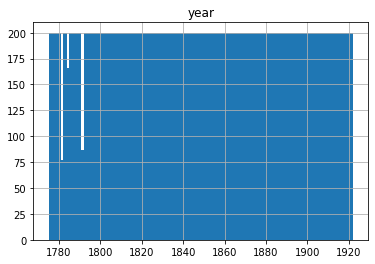

In [13]:
# histogram of datapoint distribution across years
dfPas.hist(column="year", bins=148)

In [14]:
"""
Delete rows without passages (from depleted years)
"""
print('Count before removal ',dfPas.shape[0])
dfPas = dfPas.drop(dfPas[dfPas.passage.apply(is_acceptable_length, length=(5000)) == False].index)
print('Count after removal ', dfPas.shape[0])


Count before removal  29600
Count after removal  29330


In [15]:
dfGrouped = dfPas.groupby(['test'])['test'].count().reset_index(
  name='Count').sort_values(['Count'], ascending=False)

print(dfGrouped.head())


    test  Count
0  False  22775
1   True   6555


In [16]:
from sklearn.utils import shuffle

dfPas = dfPas.copy()
dfPas = dfPas.drop(columns=['index'])
dfPas = shuffle(dfPas, random_state=1)
dfPas = dfPas.reset_index(drop=True)
dfPas.head()

,title,passage,year,test
0,the europeans,"have a charming nature; I regard that as our capital. If I had not been convinced of that I should never have taken the risk of bringing you to this dreadful country."" ""This comical country, this delightful country!"" exclaimed the young man, and he broke into the most animated laughter. ""Is it those women scrambling into the omnibus?"" asked his companion. ""What do you suppose is the attraction?"" ""I suppose there is a very good-looking man inside,"" said the young man. ""In each of them? They come along in hundreds, and the men in this country don't seem at all handsome. As for the women--I have never seen so many at once since I left the convent."" ""The women are very pretty,"" her brother declared, ""and the whole affair is very amusing. I must make a sketch of it."" And he came back to the table quickly, and picked up his utensils--a small sketching-board, a sheet of paper, and three or four crayons. He took his place at the window with these things, and stood there glancing out, plying his pencil with an air of easy skill. While he worked he wore a brilliant smile. Brilliant is indeed the word at this moment for his strongly-lighted face. He was eight and twenty years old; he had a short, slight, well-made figure. Though he bore a noticeable resemblance to his sister, he was a better favored person: fair-haired, clear-faced, witty-looking, with a delicate finish of feature and an expression at once urbane and not at all serious, a warm blue eye, an eyebrow finely drawn...",1878.0,False
1,afghanistan and the anglorussian dispute,"neighborhood of camp; they are easily controlled and cared for, and are on all accounts the most inexpensive transport in Eastern countries. [Footnote: Lieut.-Col. E. F. Chapman, C.B., R.A.] The transport animals found in India and Turkestan will be described in the parts of this book devoted to the military resources of those regions. In concluding this sketch of the ""Threshold of India,"" a mere glance at the military history of the country will suffice. In fact, only so far as it may have a bearing upon the present, has reference to the past any place in this volume. The early periods of eventful interest to Afghanistan have been already noted at the opening of this chapter. Its purely Oriental experiences were beginning to fade with the death of Nadir Shah-- variously termed the ""Butcher of Delhi,"" and the ""Wallace of Persia,"" in 1747. His progress toward India, from which he was to tear its choicest treasure and loot its greatest city, reminds one of the Arabian Nights. A camp-follower from Jelalabad reported as follows: ""He has 36,000 horsemen with himself . . . After morning prayers he sits on a throne, the canopy of which is in the form of a dome and of gold. One thousand young men, with royal standards of red silk and the lance tops and tassels of silver, are disposed regularly; and, at a proper distance, five hundred beautiful slaves, from twelve to twenty years old, stand--one half on his right and the other on his left. All the great men stand fronting him; ...",1838.0,False
2,the piccolomini,"not this! TERZKY. And if Thou loiterest longer, all will fall away, One following the other. WALLENSTEIN. Altringer Is master of the Tyrol passes. I must forthwith Send some one to him, that he let not in The Spaniards on me from the Milanese. --Well, and the old Sesin, that ancient trader In contraband negotiations, he Has shown himself again of late. What brings he From the Count Thur? TERZKY. The count communicates He has found out the Swedish chancellor At Halberstadt, where the convention's held, Who says, you've tired him out, and that he'll have No further dealings with you. WALLENSTEIN. And why so? TERZKY. He says, you are never in earnest in your speeches; That you decoy the Swedes--to make fools of them; Will league yourself with Saxony against them, And at last make yourself a riddance of them With a paltry sum of money. WALLENSTEI

In [17]:


dfTest = dfPas[dfPas['test']==True].drop(columns=['test']).reset_index(drop=True)
dfTrain = dfPas[dfPas['test']==False].drop(columns=['test']).reset_index(drop=True)
print('Training count: ', dfTrain.shape[0])
print('Testing count: ', dfTest.shape[0])

test_books = set(dfTest['title'].values.tolist())
train_books = set(dfTrain['title'].values.tolist())
books_in_common = [book for book in test_books if book in train_books]

print('Number of books in commong between the sets: ', len(books_in_common))

# dfTest.to_csv('testing.csv', index=False)
# dfTrain.to_csv('training.csv', index=False)

print(dfTest.head(2))


Training count:  22775
Testing count:  6555
Number of books in commong between the sets:  0
                      title  \
0  on the origin of species   
1                  ferragus   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

All of the years are evenly distributed, except for three years that had very sparse data - less than four books each. 1781 only has 77 instances, 1791 only 87 instances, and 1784 has 166. This may yield less exact results for these years. In general, pre-1825 results will be worse than post-1825 as the amount of books available is relatively low for these years, meaning that there is less variety of examples of each year's text.

We have manually separate the training and testing data in the methods above rather than using a library. This is because we do not want to train the model to fit a specific book, but rather a specific year, therefor we must ensure that each book is either exclusively in the testing set or in the training set. The split comes to roughly 27% testing and 63% training

In [52]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing

MAX_WORDS = 50000

x_test = dfTest['passage']
y_test = dfTest['year']

x_train = dfTrain['passage']
y_train = dfTrain['year']

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)


In [53]:
import numpy as np

MAX_LENGTH = 200

vocab_size = len(tokenizer.word_index)
print(vocab_size)
x_train = pad_sequences(x_train, padding='post', maxlen=MAX_LENGTH)
x_test = pad_sequences(x_test, padding='post', maxlen=MAX_LENGTH)

embeddings_dictionary = dict()
glove_file = open('glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    values = line.split()
    word = values[0]
    vector_dimensions = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()
print(f'Found {len(embeddings_dictionary)} word vectors')

414269
Found 400001 word vectors


In [54]:
EMBEDDING_DIMENSION = 100
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIMENSION))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index-1] = embedding_vector

In [55]:
"""
Try as regression
"""

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIMENSION, input_length=MAX_LENGTH))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.summary()

model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_absolute_error')

history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_test, y_test))
# model.save_weights('pre_trained_glove_model.h5')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 100)          41426900  
                                                                 
 flatten_6 (Flatten)         (None, 20000)             0         
                                                                 
 dense_20 (Dense)            (None, 32)                640032    
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 42,066,965
Trainable params: 640,065
Non-trainable params: 41,426,900
_________________________________________________________________
Epoch 1/10
712/712 [==============================] - 2s 2ms/step - loss: 153.8271 - val_loss: 117.3833
Epoch 2/10
712/712 [==============================] - 2s 2ms/st

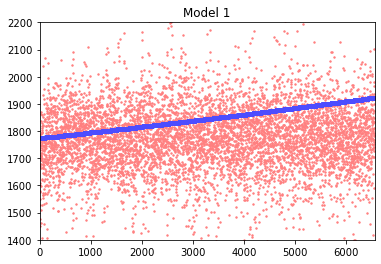

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plotGraph(test_y,pred_y,title):
    plt.scatter(range(len(pred_y)), pred_y, color=[1., 0.5, 0.5], s=2)
    plt.scatter(range(len(test_y)), test_y, color=[0.3, 0.3, 1], s=10)
    plt.axis([0, len(test_y), 1400, 2200])
    plt.title(title)
    plt.show()
    return

def create_scatterplot(test_x, test_y, current_model, title, category=False):
    test_array = np.array(x_test)
    predictions = current_model.predict(test_array)
    preds = [item for sublist in predictions for item in sublist]

    actual_and_pred = zip(list(y_test), preds)
    actual_and_pred = sorted(list(actual_and_pred),key = lambda x: x[0])
    actual, pred = [e[0] for e in actual_and_pred], [e[1] for e in actual_and_pred]
    
    plotGraph(actual, pred, title)

create_scatterplot(x_test, y_test, model, "Model 1")

205/205 [==============================] - 0s 938us/step - loss: 117.3431
Test Score: 117.34309387207031


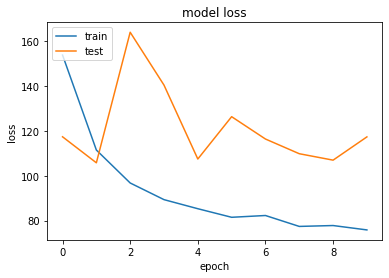

In [57]:
import matplotlib.pyplot as plt

def plot_loss(score):
    print("Test Score:", score)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()
    
plot_loss(model.evaluate(x_test, y_test, verbose=1))

In [58]:
from keras.layers import SimpleRNN

"""
Using SIMPLE RNN
"""
model2 = Sequential()
model2.add(Embedding(vocab_size, EMBEDDING_DIMENSION, weights=[embedding_matrix], input_length=MAX_LENGTH))
model2.add(SimpleRNN(units=32))
model2.add(Dense(32, activation="relu")) 
model2.add(Dense(1))
model2.layers[0].trainable = False
model2.summary()
model2.compile(loss='mean_absolute_error', optimizer='adam')

history = model2.fit(x_train, y_train,
epochs=5,
batch_size=64,
validation_data=(x_test, y_test))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 200, 100)          41426900  
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_22 (Dense)            (None, 32)                1056      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 41,432,245
Trainable params: 5,345
Non-trainable params: 41,426,900
_________________________________________________________________
Epoch 1/5
356/356 [==============================] - 8s 20ms/step - loss: 1790.9176 - val_loss: 1688.7369
Epoch 2/5
356/356 [==============================] - 7s 20ms/st

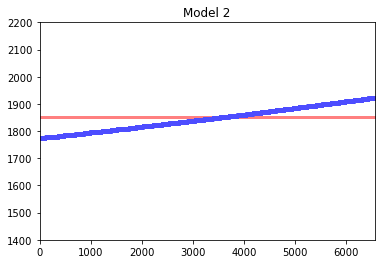

In [59]:
create_scatterplot(x_test, y_test, model2, "Model 2")

205/205 [==============================] - 6s 28ms/step - loss: 51.7635
Test Score: 51.763465881347656


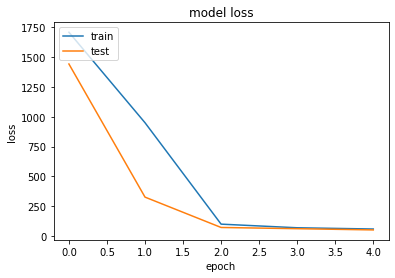

In [26]:
plot_loss(model2.evaluate(x_test, y_test, verbose=1))

In [60]:
from keras.layers import LSTM

"""
Using LSTM - (reads from both sides)
"""
model2 = Sequential()
model2.add(Embedding(vocab_size, EMBEDDING_DIMENSION, weights=[embedding_matrix], input_length=MAX_LENGTH))
model2.add(LSTM(units=32))
model2.add(Dense(32, activation="relu")) 
model2.add(Dense(1))
model2.layers[0].trainable = False
model2.summary()
model2.compile(loss='mean_absolute_error', optimizer='adam')

history = model2.fit(x_train, y_train,
epochs=5,
batch_size=64,
validation_data=(x_test, y_test))
model.save_weights('pre_trained_glove_model_lstm.h5')

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 200, 100)          41426900  
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dense_24 (Dense)            (None, 32)                1056      
                                                                 
 dense_25 (Dense)            (None, 1)                 33        
                                                                 
Total params: 41,445,013
Trainable params: 18,113
Non-trainable params: 41,426,900
_________________________________________________________________
Epoch 1/5
356/356 [==============================] - 24s 64ms/step - loss: 1774.9868 - val_loss: 1643.7104
Epoch 2/5
356/356 [==============================] - 23s 64ms

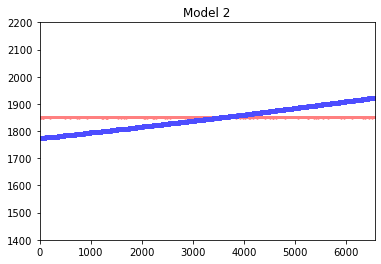

In [61]:
create_scatterplot(x_test, y_test, model2, "Model 2")

In [28]:
"""
Using SIMPLE RNN
"""
model_tw = Sequential()
model_tw.add(Embedding(vocab_size, EMBEDDING_DIMENSION, weights=[embedding_matrix], input_length=MAX_LENGTH))
model_tw.add(SimpleRNN(units=32, activation="relu"))
model_tw.add(Dense(32, activation="relu")) 
model_tw.add(Dense(1))
model_tw.add(Flatten())
model_tw.layers[0].trainable = True
model_tw.summary()
model_tw.compile(loss='mean_absolute_error', optimizer='adam')
model_tw.load_weights('pre_trained_glove_model2.h5',by_name = True, skip_mismatch = True)

history = model_tw.fit(x_train, y_train,
epochs=15,
batch_size=200,
validation_data=(x_test, y_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 900, 100)          41426900  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
 flatten_1 (Flatten)         (None, 1)                 0         
                                                                 
Total params: 41,432,245
Trainable params: 41,432,245
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
  7/114 [>.....................

KeyboardInterrupt: 

In [ ]:
create_scatterplot(x_test, y_test, model_tw, "Model Trained Weights")

In [ ]:
from keras.layers import  TextVectorization

"""
Using SIMPLE RNN
"""
model4 = Sequential()
model4.add(Embedding(vocab_size, EMBEDDING_DIMENSION, weights=[embedding_matrix], input_length=MAX_LENGTH))
model4.add(SimpleRNN(units=64, activation="relu"))
model4.add(Dense(32, activation="relu")) 
model4.add(Dense(1))
model4.add(Flatten())
model4.layers[0].trainable = False
model4.summary()
model4.compile(loss='mean_absolute_error', optimizer='adam')

history = model2.fit(x_train, y_train,
epochs=15,
batch_size=128,
validation_data=(x_test, y_test))


In [ ]:
from tensorflow.keras.utils import to_categorical

x_test_cod = dfTest['passage']
y_test_cod = dfTest['year']

x_train_cod = dfTrain['passage']
y_train_cod = dfTrain['year']

label_encoder = preprocessing.LabelEncoder()
y_test_cod = label_encoder.fit_transform(y_test_cod)
y_train_cod = label_encoder.fit_transform(y_train_cod)

y_train_cod = to_categorical(y_train_cod)
y_test_cod = to_categorical(y_test_cod)

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(x_train_cod)

x_train_cod = tokenizer.texts_to_sequences(x_train_cod)
x_test_cod = tokenizer.texts_to_sequences(x_test_cod)

In [ ]:
import numpy as np

vocab_size = len(tokenizer.word_index)

x_train_cod = pad_sequences(x_train_cod, padding='post', maxlen=MAX_LENGTH)
x_test_cod = pad_sequences(x_test_cod, padding='post', maxlen=MAX_LENGTH)

embeddings_dictionary = dict()
glove_file = open('glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    values = line.split()
    word = values[0]
    vector_dimensions = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()
print(f'Found {len(embeddings_dictionary)} word vectors')

In [ ]:
model3 = Sequential()
model3.add(Embedding(vocab_size, EMBEDDING_DIMENSION, input_length=MAX_LENGTH))
model3.add(LSTM(32, return_sequences=True))

model3.add(LSTM(32))
model3.add(Dense(148, activation='softmax'))
model3.add(Flatten())
model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = False
model3.summary()

model3.compile(optimizer=Adam(learning_rate=0.1), metrics=['acc'], loss='categorical_crossentropy')

history = model3.fit(x_train_cod, y_train_cod, batch_size=128, epochs=7, verbose=1, validation_data=(x_test_cod, y_test_cod))
model3.save_weights('pre_trained_glove_model.h5')

In [ ]:
test_array = np.array(x_test_cod)


# prediction = model.predict(test_array)
# # print(np.argmax(prediction[0]))
# print(prediction)

def plotGraph(test_y,pred_y,title):
    plt.scatter(range(len(pred_y)), pred_y, color=[1., 0.5, 0.5], s=2)
    plt.scatter(range(len(test_y)), test_y, color=[0.3, 0.3, 1], s=10)
    plt.axis([0, len(test_y), 1400, 2200])
    plt.title(title)
    plt.show()
    return

def create_scatterplot(test_x, test_y, current_model, title, category=False):
    test_array = np.array(x_test)
    predictions = current_model.predict(test_array)
    preds = [item for sublist in predictions for item in sublist]

    actual_and_pred = zip(list(y_test), preds)
    actual_and_pred = sorted(list(actual_and_pred),key = lambda x: x[0])
    actual, pred = [e[0] for e in actual_and_pred], [e[1] for e in actual_and_pred]
    
    plotGraph(actual, pred, title)

create_scatterplot(x_test, y_test, model3, "Model 3")

In [ ]:
"""
Separate into eras
"""
def write_era(row):
    if row['year'] < 1810:
        row['era'] = 1
    elif row['year'] >= 1810 and row['year'] < 1845:
        row['era'] = 2
    elif row['year'] >= 1845 and row['year'] < 1885:
        row['era'] = 3
    elif row['year'] >= 1885:
        row['era'] = 4
    return row

dfTest2 = dfTest.copy()
dfTrain2 = dfTrain.copy()
dfTest2 = dfTest2.apply(write_era, axis=1)
dfTrain2 = dfTrain2.apply(write_era, axis=1)

dfTest2.head(2)

In [ ]:
dfTrain2.hist(column='era')

In [ ]:
x_test_era = dfTest2['passage']
y_test_era = dfTest2['era']

x_train_era = dfTrain2['passage']
y_train_era = dfTrain2['era']

label_encoder = preprocessing.LabelEncoder()
y_test_era = label_encoder.fit_transform(y_test_era)
y_train_era = label_encoder.fit_transform(y_train_era)

y_train_era = to_categorical(y_train_era)
y_test_era = to_categorical(y_test_era)

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(x_train_era)

x_train_era = tokenizer.texts_to_sequences(x_train_era)
x_test_era = tokenizer.texts_to_sequences(x_test_era)

In [ ]:
import numpy as np

MAX_LENGTH = 50

vocab_size = len(tokenizer.word_index)

x_train_era = pad_sequences(x_train_era, padding='post', maxlen=MAX_LENGTH)
x_test_era = pad_sequences(x_test_era, padding='post', maxlen=MAX_LENGTH)

embeddings_dictionary = dict()
glove_file = open('glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    values = line.split()
    word = values[0]
    vector_dimensions = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()
print(f'Found {len(embeddings_dictionary)} word vectors')

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIMENSION, weights=[embedding_matrix], input_length=MAX_LENGTH))
model.add(LSTM(32))
model.add(Dense(4, activation='softmax'))
model.add(Flatten())
model.layers[0].trainable = False
model.summary()

model.compile(optimizer=Adam(learning_rate=0.01), metrics=['acc'], loss='categorical_crossentropy')

history = model.fit(x_train_era, y_train_era, batch_size=128, epochs=7, verbose=1, validation_data=(x_test_era, y_test_era))


In [ ]:
prediction = model.predict(x_test_era)
# print(np.argmax(prediction[0]))
for pred in prediction:
    print(pred)
# print(prediction)
